# Credit card fraud detection

This notebook will test fraud detection method using DL autoencoder. 

Context
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Inspiration
Identify fraudulent credit card transactions.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

My solution is to use anomaly detection with autoencoders .






![](https://www.google.com/search?q=autoencoder+for+anomaly+detection+keras&rlz=1C1GCEA_enIL866IL866&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiQztaRleLoAhWrBWMBHRKfCe8Q_AUoAnoECAwQBA&biw=1920&bih=937#imgrc=t8UiO_9h1cy-UM)

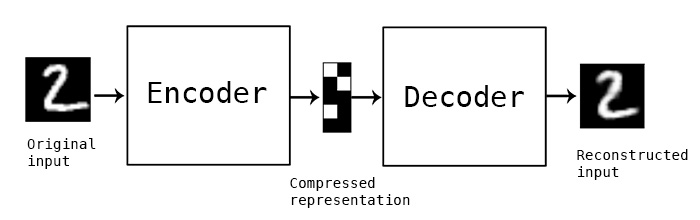

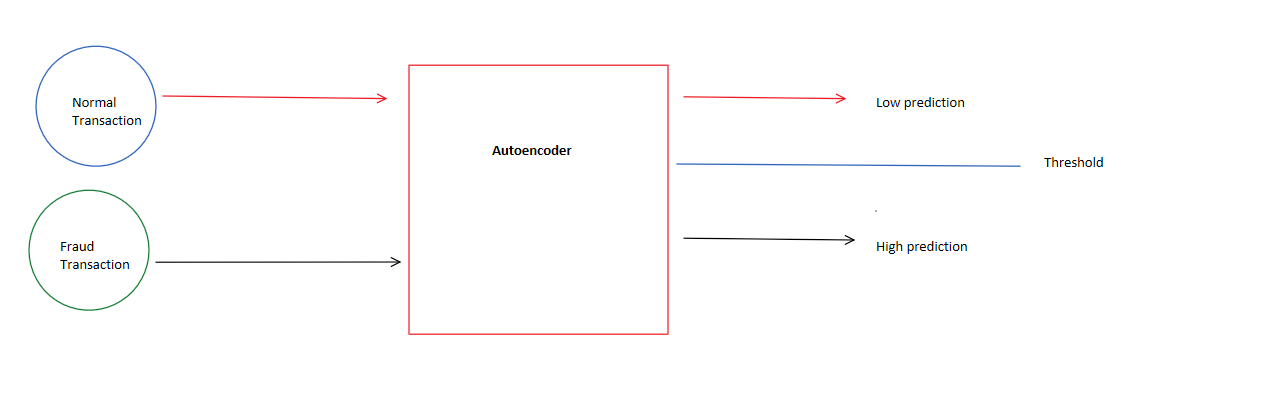

# Imports

In [1]:
import numpy as np
import pandas as pd 
import zipfile
from keras.preprocessing.image import ImageDataGenerator, load_img
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from subprocess import check_output
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import pickle
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support
from sklearn.model_selection import train_test_split


%matplotlib inline
print(check_output(["ls", "../input/"]).decode("utf8"))




Using TensorFlow backend.


creditcard.csv



# Read Data from credit CSV

In [2]:
try:
    data = pd.read_csv("../input/creditcard.csv")
except Exception as e:
    data = pd.read_csv("creditcard.csv")
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


# we can see the V1-V28 (28 features extracted from PCA on original data )

Let's see if we have missing data

In [3]:
data.isnull().values.any()


False

# Check how much examples we have per Class

count for each class : 

0    284315
1       492
Name: Class, dtype: int64

percent of fraud : 0.1727485630620034%


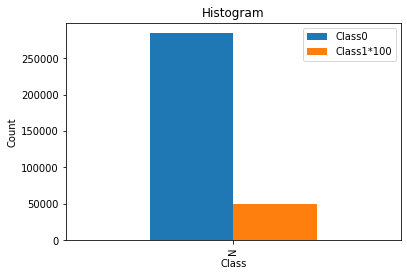

In [4]:
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()

df = pd.DataFrame({'Class0':count_classes[0], 'Class1*100':count_classes[1]*100}, index=['N']) #
df.plot(kind='bar')
plt.title("Histogram")
plt.xlabel("Class")
plt.ylabel("Count")

print("count for each class : \n\n" + str(count_classes) + "\n")
print ('percent of fraud : ' + str(100*count_classes[1]/(sum(count_classes))) + "%")

# Since Amount feature is unbalance and can get high values comapring to other V1-V28 features I'll center the data using fit transform

I'll drop Time feature since it didn't improve loss & acc

In [5]:

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
#data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data = data.drop(['Time'],axis=1) #,'Amount'
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


# Train test split

In [6]:
bad_data = data[data['Class'] == 1]
bad_data2=bad_data['Class']
bad_data=bad_data.drop(['Class'], axis=1)
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

X_train = X_train[X_train['Class']==0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_test2=np.concatenate([bad_data, X_test])
y_test2 = np.concatenate([bad_data2, y_test])


# Model parmeters

In [7]:
input_dim = X_train.shape[1]
encoding_dim = 14
nb_epoch = 15
batch_size = 32

# Auto encoder model
# DL network will have Autoencoder which use 4 fully connected layers :
# Input(29)->Decoder(14->7) ->Encoder(14->29)->output(29)
 

In [8]:


input_layer = Input(shape=(input_dim, ))

encoder = Dense(18, activation="relu")(input_layer)
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l2(10e-3))(encoder) #regularizers.l1(10e-5)
encoder = Dense(int(encoding_dim / 2)+2, activation="relu")(encoder)

decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 18)                540       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                266       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 135       
_________________________________________________________________
dense_3 (Dense)              (None, 14)                140       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                435       
Total params: 1,516
Trainable params: 1,516
Non-trainable params: 0
___________________________________________________________

># Train Model

In [9]:
checkpointer = ModelCheckpoint(filepath="fraud_model.h5",verbose=0,save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)

history = autoencoder.fit(X_train, X_train,epochs=nb_epoch,batch_size=batch_size,shuffle=True,validation_data=(X_test2, X_test2),verbose=1,callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 57454 samples
Epoch 1/15
227451/227451 [==============================] - 19s 82us/sample - loss: 0.7957 - accuracy: 0.5614 - val_loss: 1.0033 - val_accuracy: 0.6283
Epoch 2/15
227451/227451 [==============================] - 19s 82us/sample - loss: 0.7254 - accuracy: 0.6589 - val_loss: 0.9845 - val_accuracy: 0.6717
Epoch 3/15
227451/227451 [==============================] - 18s 81us/sample - loss: 0.7119 - accuracy: 0.6858 - val_loss: 0.9738 - val_accuracy: 0.6849
Epoch 4/15
227451/227451 [==============================] - 18s 78us/sample - loss: 0.7056 - accuracy: 0.6988 - val_loss: 0.9693 - val_accuracy: 0.7045
Epoch 5/15
227451/227451 [==============================] - 18s 78us/sample - loss: 0.7014 - accuracy: 0.7062 - val_loss: 0.9642 - val_accuracy: 0.7006
Epoch 6/15
227451/227451 [==============================] - 18s 81us/sample - loss: 0.6956 - accuracy: 0.7147 - val_loss: 0.9574 - val_accuracy: 0.7136
Epoch 7/15
227451/227451 [===========

# Plot Loss & Accuracy over epoch

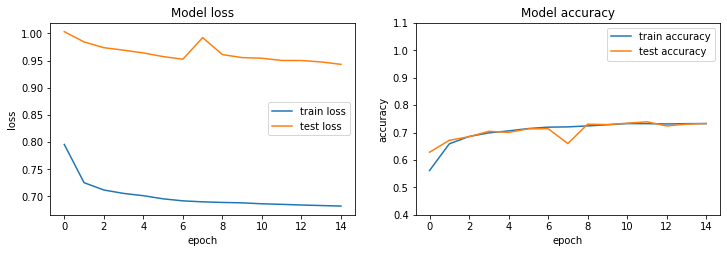

In [10]:
autoencoder = load_model('fraud_model.h5')
plt.figure(figsize=(12,12))

plt.subplot(321)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss']);#loc='upper right'

plt.subplot(322)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0.4,1.1)
plt.legend(['train accuracy','test accuracy']);#loc='upper right'


# Predict test data & calculate MSE error

In [11]:
predictions = autoencoder.predict(X_test2)
mse = np.mean(np.power(X_test2 - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test2})

# Calculate Precision Vs Recall curve & AUPRC measure
https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/

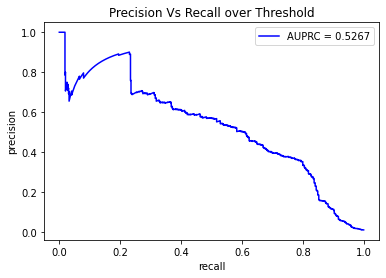

In [12]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
auprc = auc(recall, precision)

plt.plot(recall, precision, 'b')
plt.title('Precision Vs Recall over Threshold')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(['AUPRC = %0.4f'% auprc])
plt.show()

# Calculate F1 Score

In [13]:
F1_score=[]
F1_score = 2 * (precision * recall) / (precision + recall)
print('Maximal F1 Score : ', str(max(F1_score)))
optimal_th = th[np.argmax(F1_score)]


Maximal F1 Score :  0.5507246376811595


# Show Precision & Recall Vs Threshold

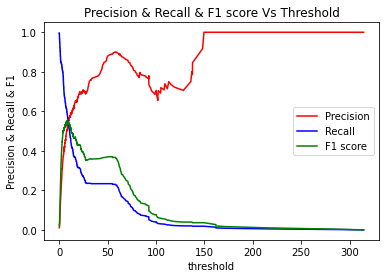

In [14]:
plt.plot(th, precision[1:], 'r', label='Threshold-Precision curve')
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.plot(th, F1_score[1:], 'g', label='Threshold-Recall curve')

plt.title('Precision & Recall & F1 score Vs Threshold')
plt.xlabel('threshold')
plt.ylabel('Precision & Recall & F1')
plt.legend(['Precision','Recall', 'F1 score'])

plt.show()

# Visual optimal Threshold(gives max F1 score) with Fraud & legal transactions

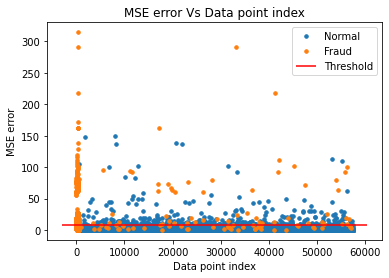

In [15]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(optimal_th, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("MSE error Vs Data point index")
plt.ylabel("MSE error")
plt.xlabel("Data point index")
plt.show();

Huge thanks to 
https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb